In [1]:
import tensorflow as tf
import numpy as np
import mnist_handler
import matplotlib.pyplot as plt

INPUT_DIMENSION = 28*28
NUM_CLASSES = 10

"""load MNIST"""
x_train, x_test, y_train, y_test = mnist_handler.load_mnist('mnist.npz')
x_train = x_train/25500.0
x_test = x_test/25500.0
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

border = 5000
x_train_init = x_train[:border]
y_train_init = y_train[:border]
x_train_seq = x_train[border:]
y_train_seq = y_train[border:]

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [2]:
tf.reset_default_graph() # clear all the tensors

In [3]:
sess = tf.Session()



In [4]:
"""Placeholders"""
X = tf.placeholder(tf.float32, [None, 28, 28])
X_ = tf.reshape(X, [-1, INPUT_DIMENSION]) # Flatten X: [N,D]
Y = tf.placeholder(tf.int64, [None]) # labels
Y_ = tf.one_hot(indices=Y, depth=NUM_CLASSES) # one_hot labels: [N,M]

In [5]:
"""Some constants"""
D = INPUT_DIMENSION
M = NUM_CLASSES # Number of outputs
C = tf.constant(2.0**(-10))

In [6]:
"""Weights"""
alpha_1 = tf.get_variable('alpha_1',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 1st subnetwork
alpha_2 = tf.get_variable('alpha_2',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 2st subnetwork


In [7]:
"""Utility functions"""
def mul(A, B):
    return tf.matmul(A, B)

def inv(A):
    return tf.matrix_inverse(A)

def t(A):
    return tf.transpose(A)

def sin(A):
    return tf.math.sin(A)

def asin(A):
    return tf.math.asin(A)

def sqrt(A):
    return tf.sqrt(A)

# Initial Training

In [8]:
"""Initial Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
'''some pre-computations'''
X_init = t(X_) # [D,N]
Y_init = t(Y_) # [M,N]
N_init = D # number of dimensions
I_init = tf.eye(N_init, dtype=tf.float32) # [D,D]
C_I_init = I_init/C # [D,D]
X_t_init = t(X_init) # [N,D]
X_inv_init = mul(X_t_init, inv(C_I_init + mul(X_init, X_t_init))) # [N,D]

'''1st subnet'''
alpha_1_init_calculated = t(mul(asin(Y_init), X_inv_init)) # ([M,N]x[N,D])T=[D,M]
alpha_1_init = tf.assign(alpha_1, alpha_1_init_calculated) # [D,M]
H_1_init = sin(mul(t(alpha_1_init), X_init)) # output of the first sub-network node: [M,N]
E_1_init = Y_init - H_1_init # [M,N]

'''2nd subnet'''
alpha_2_init_calculated = t(mul(asin(E_1_init), X_inv_init)) # [D,M]
alpha_2_init = tf.assign(alpha_2, alpha_2_init_calculated) # [D,M]
H_2_init = H_1_init + sin(mul(t(alpha_2_init), X_init)) # output of the first 2 sub-network nodes: [M,N]
E_2_init = Y_init - H_2_init # [M,N]

init_train_graph = E_2_init

In [9]:
"""Evaluate initial-training graph"""
logits_init = t(mul(t(alpha_1_init), t(X_)) + mul(t(alpha_2_init), t(X_)))
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [10]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [11]:
"""Initial training"""
sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Initial training done")

Initial training done


In [12]:
"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial train training loss:  0.089884646
Initial train training accuracy:  0.72321665
Initial train testing loss:  0.09741023
Initial train testing accuracy:  0.6968


# Sequential Training

In [13]:
"""Sequential Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)



'Sequential Training Graph'

[[0.00509858]
 [0.00379084]
 [0.00579013]
 [0.00566499]
 [0.00263103]
 [0.00403825]
 [0.00490783]
 [0.00245494]
 [0.00493334]
 [0.00301974]]


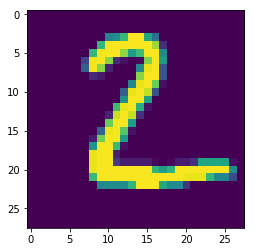

In [14]:
print(sess.run(mul(t(alpha_2), t(X_)), feed_dict={X: [x_test[1]]}))
plt.imshow(x_test[1])

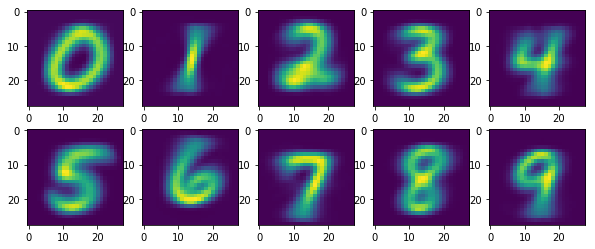

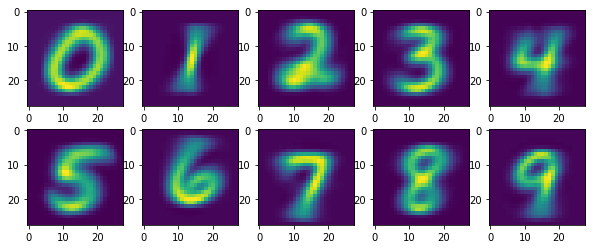

In [15]:
def visualize_alpha(alpha, size):
    tmp = sess.run(alpha)
    plt.figure(figsize=(10,4))
    for i in range(2):
        for j in range(5):
            plt.subplot(2,5,i*5+j+1)
            plt.imshow(np.reshape(tmp[:,i*5+j], [size,size]))

"""visualize subnet nodes"""            
visualize_alpha(alpha_1, 28)
visualize_alpha(alpha_2, 28)

In [16]:

def visualize_beta(beta):
    tmp = sess.run(beta)
    plt.figure(figsize=(4,4))
    plt.imshow(tmp)
    
visualize_beta(beta_1)

NameError: name 'beta_1' is not defined

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(x_train_encoded)
target_ids = range(10)

from matplotlib import pyplot as plt
plt.figure(figsize=(5, 4))
colors = 'r', 'g', 'b',
for i, c, label in zip(target_ids, colors, ['0','1','2','3','4','5','6','7','8','9']):
    plt.scatter(X_2d[y_train == i, 0], X_2d[y_train == i, 1], c=c, label=label,marker = '.')
plt.legend()
plt.show()